# Demo for Top-down Neural Attention

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [1]:
# This is a modification in using our own imageNet data
# and using standard Alexnet

import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe

We first load the model files and set the top layers' name.

In [2]:
caffe.set_mode_gpu()
net = caffe.Net('../models/bvlc_alexnet/deploy.prototxt',
                '../models/bvlc_alexnet/bvlc_alexnet.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../models/bvlc_alexnet/synset_words.txt')
param = dict()
imgScale = 227
dcBlobName = 'prob'
dcLayerName = 'prob'
topBlobName = 'fc8'
topLayerName = 'fc8'
secondTopLayerName = 'fc7'
secondTopBlobName = 'fc7'

We load an image. 
The image is resized to 224 for the shortest dimension.
Since the provided CNN model is converted to a fully convolutional model, we can input images of arbitrary aspect ratio.

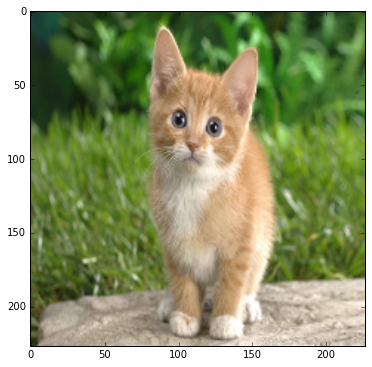

In [3]:
# imgName = '/data1/imagenet-data/raw-data/train/n15075141/n15075141_999.JPEG'
imgName = '../examples/images/cat.jpg'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])
# newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
newSize = (imgScale, imgScale )
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

We do a forward pass and show the top predictions.

In [4]:
net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = dcLayerName)
print(net.blobs[topBlobName].data[0].shape)
scores = net.blobs[topBlobName].data[0].flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
(1000,)
[('n02124075 Egyptian cat', 0.67323357), ('n02123045 tabby', 0.055200852), ('n07714990 broccoli', 0.04589086), ('n02119022 red fox', 0.037573986), ('n02123159 tiger cat', 0.036225364), ('n02094258 Norwich terrier', 0.025013659), ('n02119789 kit fox', 0.022611927), ('n02127052 lynx', 0.012857265), ('n02113023 Pembroke', 0.011181201), ('n02441942 weasel', 0.0091265347)]


Now we try to visualize several object categories present in this image using our contrastive attention formulation.  

1.0
(1000, 4096)
(1, 4096)
1.0
(1000, 4096)
(1, 4096)
1.0
(1000, 4096)
(1, 4096)
1.0
(1000, 4096)
(1, 4096)


/usr/local/lib/python2.7/dist-packages/skimage/_shared/utils.py:174: skimage_deprecation: Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be removed in a future release.
  "Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be "


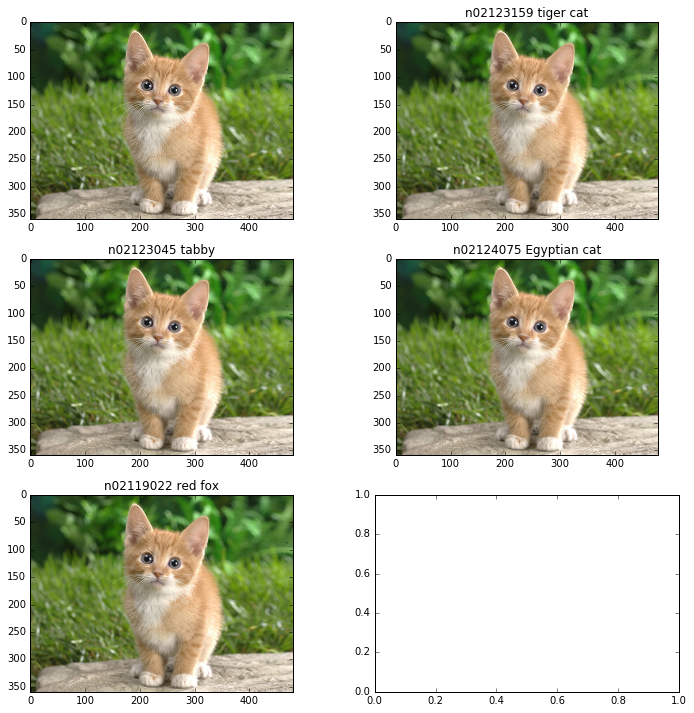

In [5]:
# switch to the excitation backprop mode
caffe.set_mode_eb_gpu() 
# specify the tags
tagName = ['n02123159 tiger cat', 'n02123045 tabby', 'n02124075 Egyptian cat', 'n02119022 red fox']
#specify the output lyer name
outputLayerName = 'conv1'
outputBlobName = 'conv1'

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID].copy())
    net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()
    print( net.blobs[topBlobName].diff[0][tagID] )
    # invert the top layer weights
    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()
    print net.params[topLayerName][0].data.shape
    print buff.shape
    # invert back
    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)

    # compute the contrastive signal
    net.blobs[secondTopBlobName].diff[...] -= buff

    out = net.backward(start = secondTopLayerName, end = outputLayerName)
    attMap = np.maximum(net.blobs[outputBlobName].diff[0].sum(0), 0)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)


We also compare with the deconvolution method.

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
util.py:39: RuntimeWarning: invalid value encountered in divide
  attMap /= attMap.max()
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. U

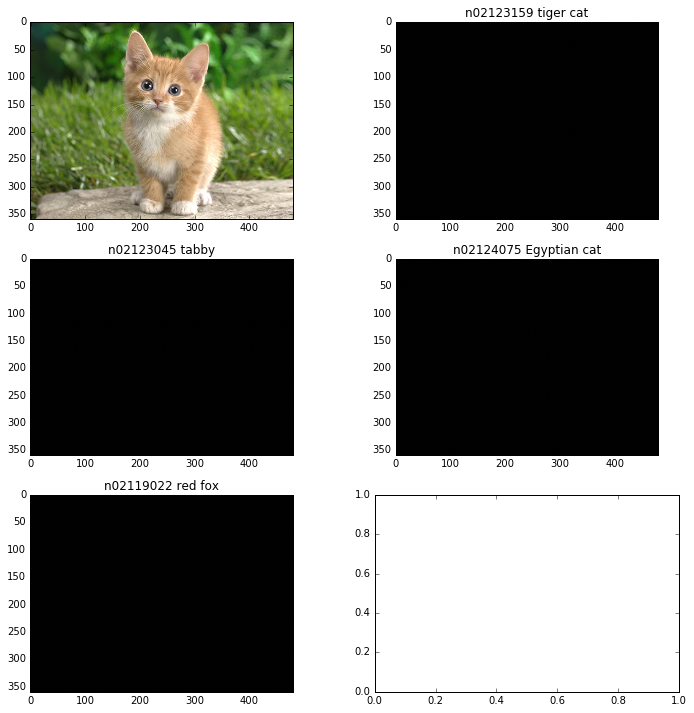

In [6]:
# switch to the deconvolution mode
caffe.set_mode_dc_gpu() 
tagName = ['n02123159 tiger cat', 'n02123045 tabby', 'n02124075 Egyptian cat', 'n02119022 red fox']
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[dcBlobName].diff[0][...] = 0
    net.blobs[dcBlobName].diff[0][tagID] = np.exp(net.blobs[dcBlobName].data[0][tagID])
    out = net.backward(start = dcLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)

Compare with the gradient method

282
0.0362254
281
0.0552009
285
0.673234
277
0.037574


/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


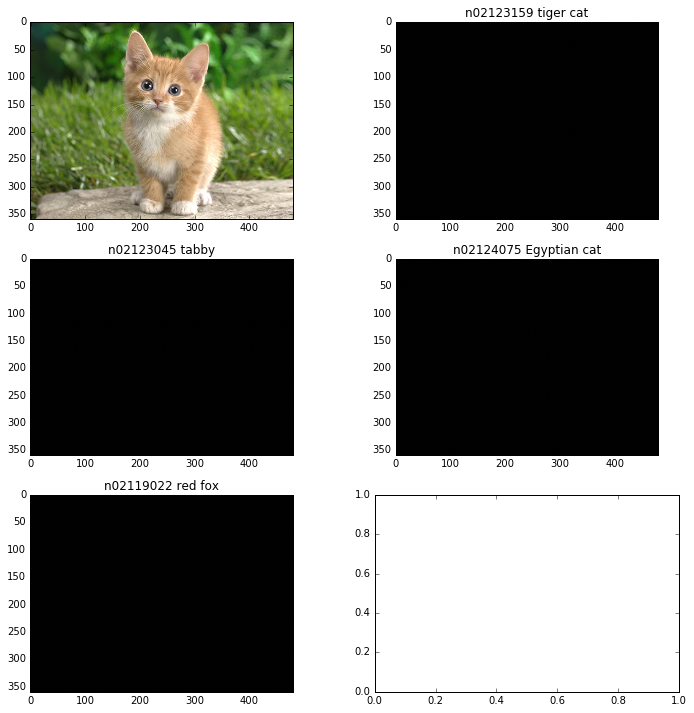

In [7]:
# Switch to the normal error backpropagation mode
caffe.set_mode_gpu() 
tagName = ['n02123159 tiger cat', 'n02123045 tabby', 'n02124075 Egyptian cat', 'n02119022 red fox']
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    print(tagID)
    net.blobs[dcBlobName].diff[0][...] = 0
    val = net.blobs[dcBlobName].data[0][tagID]
    net.blobs[dcBlobName].diff[0][tagID] = val
    print(val)
    out = net.backward(start = dcLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)